In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

## Load Your Dataset
Replace the path below with the actual location of your CSV or Parquet file.

In [2]:
final_demo = pd.read_csv ('https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_demo.txt')
# A list revealing which clients were part of the grand experiment
df_final_experiment_clients = pd.read_csv ('https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_experiment_clients.txt')
# A detailed trace of client interactions online, divided into two parts: 
# pt_1 and pt_2. It's recommended to merge these two files prior to a comprehensive data analysis.
df_final_web_data_pt_1 = pd.read_csv ('https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_web_data_pt_1.txt')
df_final_web_data_pt_2 = pd.read_csv ('https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_web_data_pt_2.txt')
# pt1 and pt2 are combined
combined = pd.concat([df_final_web_data_pt_1,df_final_web_data_pt_1], ignore_index=True)
# Example: Read CSV
# combined = pd.read_csv("combined.csv")

# Preview data
combined.head()

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


## Preprocessing and Feature Engineering

In [3]:

# Convert date_time to datetime format
combined['date_time'] = pd.to_datetime(combined['date_time'])

# Sort for step sequencing
combined = combined.sort_values(by=['visitor_id', 'visit_id', 'date_time'])

# Calculate time spent on each step
combined['next_time'] = combined.groupby(['visitor_id', 'visit_id'])['date_time'].shift(-1)
combined['time_spent'] = (combined['next_time'] - combined['date_time']).dt.total_seconds()

# Map process_step to an ordered number
step_order = {step: i+1 for i, step in enumerate(combined['process_step'].unique())}
combined['step_number'] = combined['process_step'].map(step_order)
combined['next_step'] = combined.groupby(['visitor_id', 'visit_id'])['step_number'].shift(-1)
combined['step_change'] = combined['next_step'] - combined['step_number']
combined['backward_flag'] = combined['step_change'] < 0

combined.head()


,client_id,visitor_id,visit_id,process_step,date_time,next_time,time_spent,step_number,next_step,step_change,backward_flag
101048,6265388,100019786_4272121951,703380671_89376183829_330646,start,2017-04-15 15:13:33,2017-04-15 15:13:33,0.0,1,1.0,0.0,False
444189,6265388,100019786_4272121951,703380671_89376183829_330646,start,2017-04-15 15:13:33,2017-04-15 15:13:46,13.0,1,2.0,1.0,False
101047,6265388,100019786_4272121951,703380671_89376183829_330646,step_1,2017-04-15 15:13:46,2017-04-15 15:13:46,0.0,2,2.0,0.0,False
444188,6265388,100019786_4272121951,703380671_89376183829_330646,step_1,2017-04-15 15:13:46,2017-04-15 15:14:21,35.0,2,3.0,1.0,False
101046,6265388,100019786_4272121951,703380671_89376183829_330646,step_2,2017-04-15 15:14:21,2017-04-15 15:14:21,0.0,3,3.0,0.0,False


## Visualization: Average Time per Step

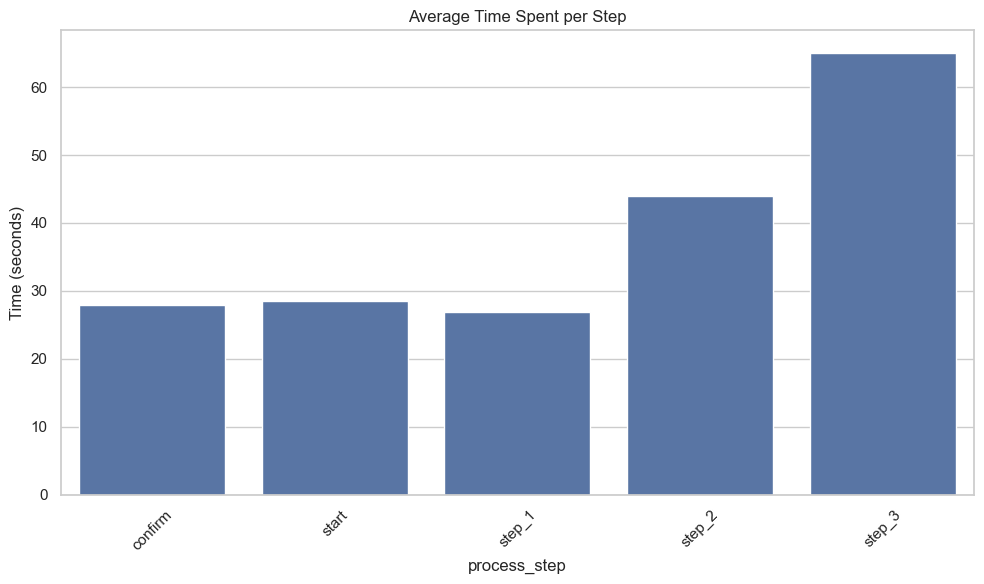

In [4]:

avg_time = combined.groupby('process_step')['time_spent'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_time, x='process_step', y='time_spent')
plt.title('Average Time Spent per Step')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Visualization: Error Rate (Backward Navigation) per Step

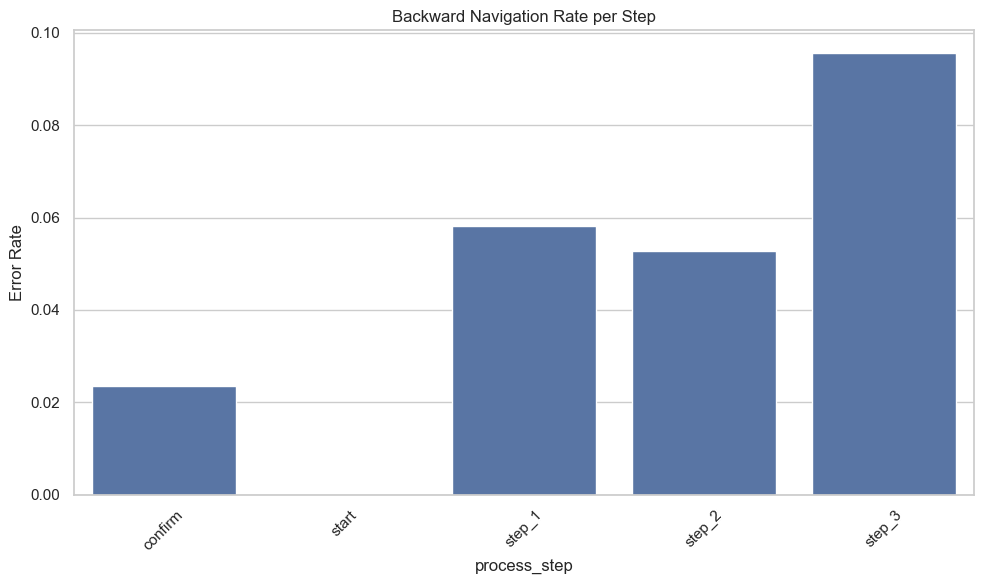

In [5]:

error_rate = combined.groupby('process_step')['backward_flag'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=error_rate, x='process_step', y='backward_flag')
plt.title('Backward Navigation Rate per Step')
plt.ylabel('Error Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Visualization: Completion Funnel

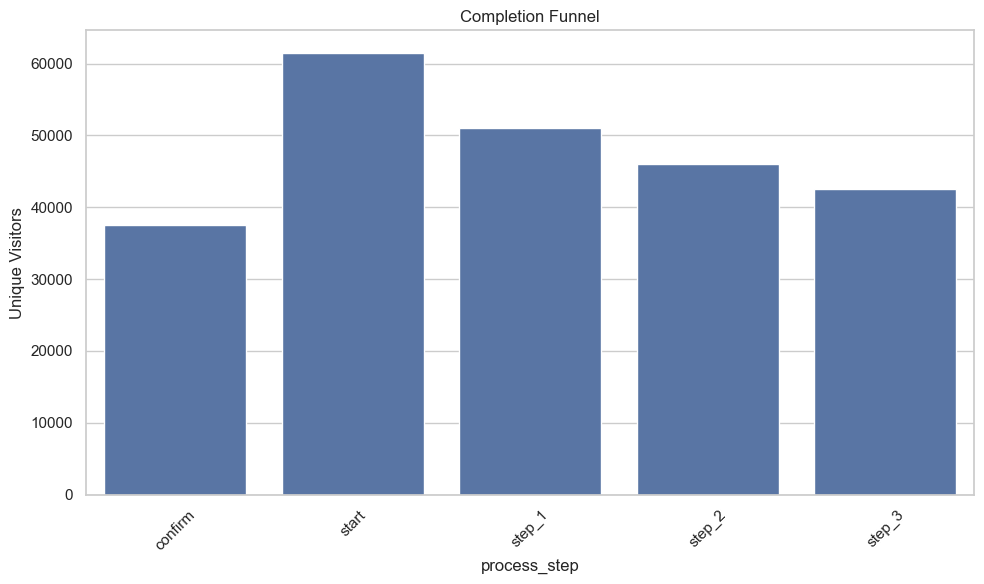

In [6]:

funnel = combined.groupby('process_step')['visitor_id'].nunique().reset_index()
funnel = funnel.sort_values(by='process_step')

plt.figure(figsize=(10, 6))
sns.barplot(data=funnel, x='process_step', y='visitor_id')
plt.title('Completion Funnel')
plt.ylabel('Unique Visitors')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Hypothesis Test: Step 1 vs Step 2 Time Comparison

In [15]:
import pandas as pd
from scipy.stats import ttest_ind

# Ensure datetime
combined['date_time'] = pd.to_datetime(combined['date_time'])

# Sort properly
combined = combined.sort_values(['client_id', 'visit_id', 'date_time'])

# Compute time spent on each step as difference to next step
combined['time_spent'] = combined.groupby(['client_id', 'visit_id'])['date_time'].shift(-1) - combined['date_time']
combined['time_spent'] = combined['time_spent'].dt.total_seconds()

# Optional: if last step per visit has NaN, you can drop it or set to 0
combined['time_spent'] = combined['time_spent'].fillna(0)

# Check a few values
combined[['client_id', 'visit_id', 'process_step', 'time_spent']].head(10)

# Now you can run your t-test
step1_times = combined[combined['process_step'] == 'Step 1']['time_spent']
step2_times = combined[combined['process_step'] == 'Step 2']['time_spent']

t_stat, p_val = ttest_ind(step1_times, step2_times, equal_var=False)
print(f"T-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")

T-statistic: nan, p-value: nan


In [19]:
step1_times = combined[combined['process_step']=='Step 1']['time_spent'].dropna()
step2_times = combined[combined['process_step']=='Step 2']['time_spent'].dropna()

t_stat, p_val = ttest_ind(step1_times, step2_times)
print(f"T-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")

T-statistic: nan, p-value: nan


## Average Time per Step by Age Group

In [22]:
demo_cols = ['client_id', 'clnt_age', 'gendr', 'clnt_tenure_yr']

# Merge demographic info into combined
combined = combined.merge(final_demo[demo_cols], on='client_id', how='left')

# Make sure numeric
combined['clnt_age'] = pd.to_numeric(combined['clnt_age'], errors='coerce')
combined['clnt_tenure_yr'] = pd.to_numeric(combined['clnt_tenure_yr'], errors='coerce')

# Create age group
combined['age_group'] = pd.cut(
    combined['clnt_age'],
    bins=[0, 25, 35, 50, 65, 100],
    labels=['<25', '25-35', '35-50', '50-65', '65+']
)

# Copy gender and tenure_years columns
combined['gender'] = combined['gendr']
combined['tenure_years'] = combined['clnt_tenure_yr']

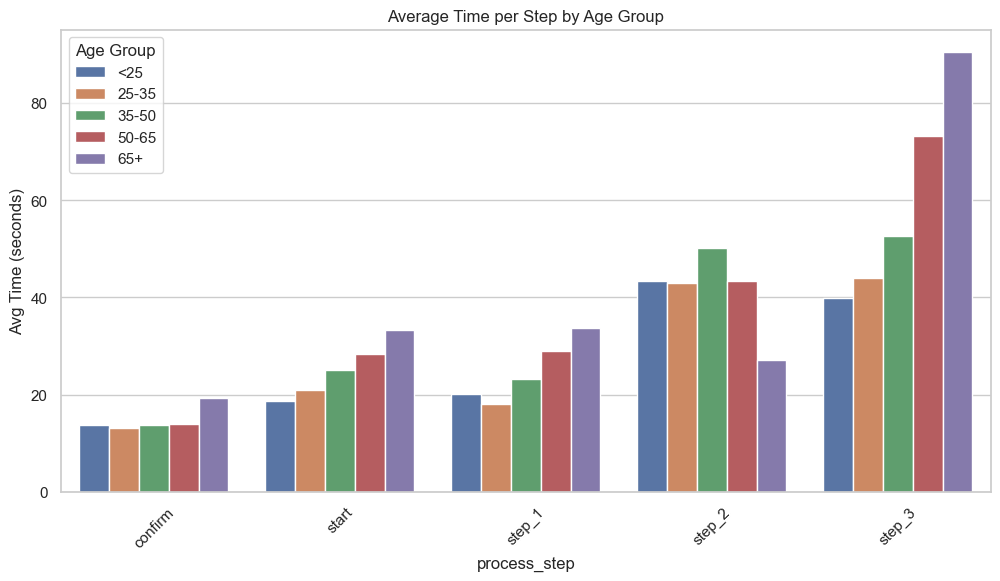

In [28]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=combined.groupby(['process_step','age_group'])['time_spent'].mean().reset_index(),
    x='process_step', y='time_spent', hue='age_group'
)
plt.title('Average Time per Step by Age Group')
plt.ylabel('Avg Time (seconds)')
plt.xticks(rotation=45)
plt.legend(title='Age Group')
plt.show()

## Error Rate per Step by Gender

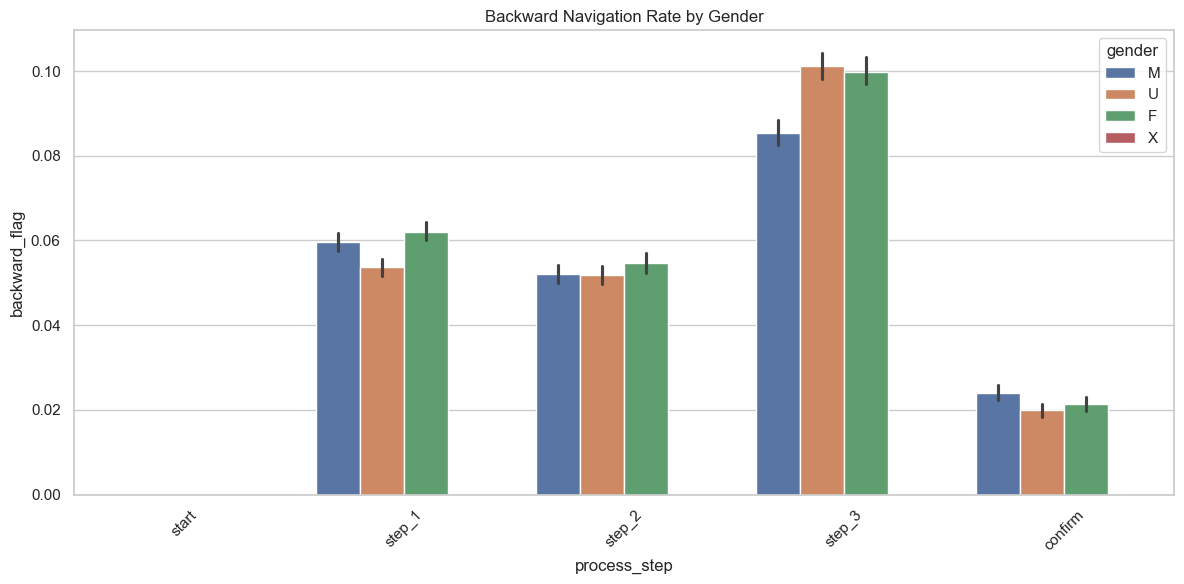

In [29]:

plt.figure(figsize=(12, 6))
sns.barplot(data=combined, x='process_step', y='backward_flag', hue='gender')
plt.title('Backward Navigation Rate by Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Cohort Analysis: Time per Step by Tenure Group

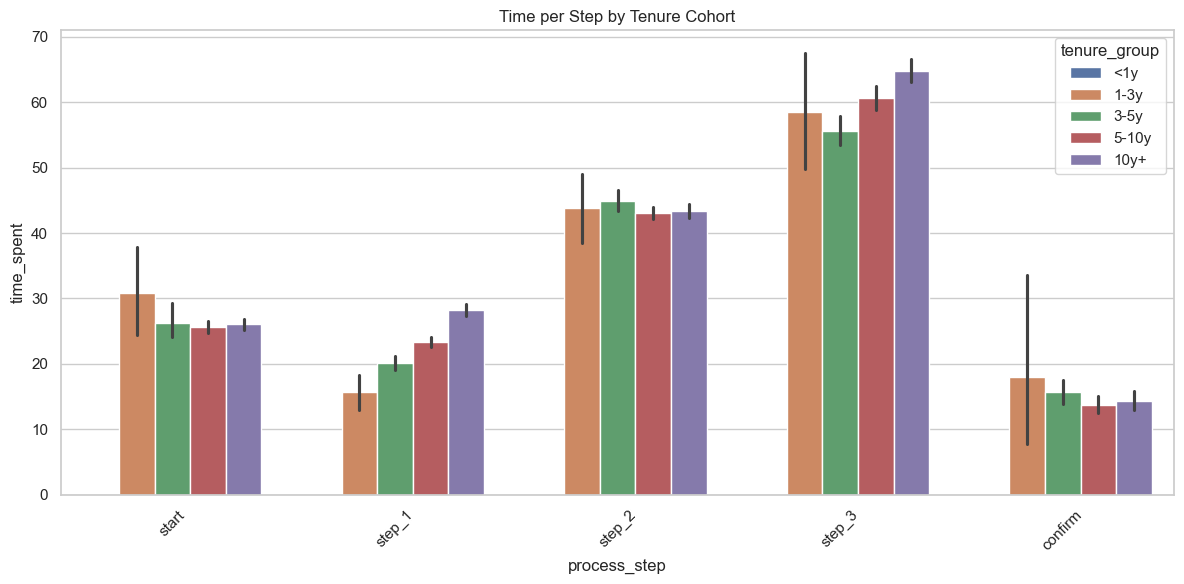

In [30]:

# Bin tenure into cohorts
combined['tenure_group'] = pd.cut(combined['tenure_years'], bins=[0, 1, 3, 5, 10, 20], labels=['<1y', '1-3y', '3-5y', '5-10y', '10y+'])

plt.figure(figsize=(12, 6))
sns.barplot(data=combined, x='process_step', y='time_spent', hue='tenure_group')
plt.title('Time per Step by Tenure Cohort')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Funnel Drop-Off by Age Group

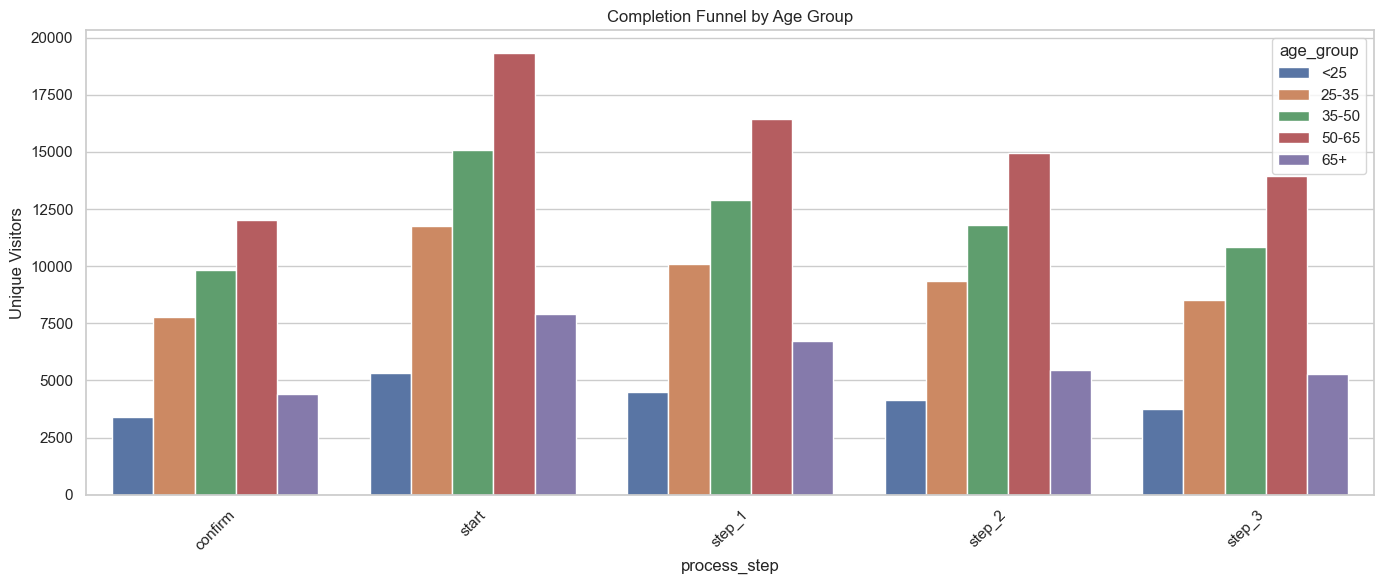

In [31]:

funnel_age = combined.groupby(['process_step', 'age_group'])['visitor_id'].nunique().reset_index()

plt.figure(figsize=(14, 6))
sns.barplot(data=funnel_age, x='process_step', y='visitor_id', hue='age_group')
plt.title('Completion Funnel by Age Group')
plt.ylabel('Unique Visitors')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()